# Проект по маркетингу

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель:** предсказать вероятность покупки в течение 90 дней.

**Задачи:**   
 1. Изучить данные.
 2. Разработать полезные признаки.
 3. Создать модель для классификации пользователей.
 4. Улучшить модель и максимизировать метрику roc-auc.
 5. Выполнить тестирование.

# Описание данных

Данные представлены в трех датасетах:


1. `apparel-purchases` - история покупок
    - client_id - идентификатор пользователя
    - quantity - количество товаров в заказе
    - price - цена товара
    - category_ids - вложенные категории, к которым отнсится товар
    - date - дата покупки
    - message_id - идентификатор сообщения из рассылки
2. `apparel-messages` - история рекламных рассылок
    - bulk_campaign_id - идентификатор рекламной кампании
    - client_id - идентификатор пользователя
    - message_id - идентификатор сообщений
    - event - тип действия
    - channel - канал рассылки
    - date - дата рассылки
    - created_at - точное время создания сообщения
3. `apparel-target_binary` - совершит ли клиент покупку в течение следующих 90 дней
   - client_id - идентификатор пользователя
   - **target - целевой признак**

# 1. Изучение данных

In [1]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
!pip install phik
!pip install imbalanced-learn
!pip install xgboost

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import ast
import numpy as np
import phik
import warnings

from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm

In [4]:
purchases = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Masterskaya_2/apparel-purchases.csv')
messages = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Masterskaya_2/apparel-messages.csv')
target = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Masterskaya_2/apparel-target_binary.csv')

In [5]:
display(purchases.head(5))
display(messages.head(5))
display(target.head(5))

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [6]:
print(purchases.info(), messages.info(show_counts=True), target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Non-Null Count     Dtype 
---  ------            --------------     ----- 
 0   bulk_campaign_id  12739798 non-null  int64 
 1   client_id         12739798 non-null  int64 
 2   message_id        12739798 non-null  object
 3   event             12739798 non-null  object
 4   channel           12739798 non-null  object
 5   date          

Пропуски в данных отсутсвуют. Типы данных в `purchases`, `messages` нужно исправить.

In [7]:
purchases['price'] = purchases['price'].astype(int)
purchases['date'] = pd.to_datetime(purchases['date'], format = '%Y-%m-%d')

messages['date'] = pd.to_datetime(messages['date'], format = '%Y-%m-%d')
messages['created_at'] = pd.to_datetime(messages['created_at'], format = '%Y-%m-%dT%H:%M:%S')

print(purchases.info(), messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  int64         
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64

Перед исследованием данных объединим датасеты в единый `df`.

In [8]:
print(f'Количество выявленных явных дубликатов в purchases: {purchases.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов в messages: {messages.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов target: {target.duplicated().sum()}')

Количество выявленных явных дубликатов в purchases: 73020
Количество выявленных явных дубликатов в messages: 48610
Количество выявленных явных дубликатов target: 0


In [9]:
purchases = purchases.drop_duplicates()
messages = messages.drop_duplicates()

In [10]:
print(f'Количество выявленных явных дубликатов в purchases: {purchases.duplicated().sum()}')
print(f'Количество выявленных явных дубликатов в messages: {messages.duplicated().sum()}')

Количество выявленных явных дубликатов в purchases: 0
Количество выявленных явных дубликатов в messages: 0


Проверим данные на уникальные, но не все столбцы, так как многие признаки удобнее будет изучать и при необходимости корректировать при исследовательском анализе с визуализацией.

In [11]:
def check (df, column):
    """
    Функция выводит:
    - Уникальные значения в столбце
    - Количество уникальных значений
    - Количество пропущенных значений (NaN)
    """
    
    print(f"Уникальные значения: {df[column].unique()}")
    print(f"Количество уникальных значений: {df[column].nunique()}")
    print(f"Количество пропущенных значений: {df[column].isna().sum()}")

In [12]:
check (purchases, 'client_id')

Уникальные значения: [1515915625468169594 1515915625471138230 1515915625471640575 ...
 1515915626010439406 1515915626010443527 1515915626010443624]
Количество уникальных значений: 49849
Количество пропущенных значений: 0


Количество уникальных значений идентификаторов клиентов совпадает с длиной датасета `target`.

In [13]:
check (purchases, 'quantity')

Уникальные значения: [ 1  2  3 10  4 25 20 13 30 15  6 18  8  9  5  7]
Количество уникальных значений: 16
Количество пропущенных значений: 0


In [14]:
check (purchases, 'price')

Уникальные значения: [ 1999  2499  6499 ... 15904  9500 13173]
Количество уникальных значений: 3642
Количество пропущенных значений: 0


In [15]:
check (purchases, 'category_ids')

Уникальные значения: ["['4', '28', '57', '431']" "['4', '28', '244', '432']"
 "['4', '28', '49', '413']" "['2', '18', '258', '441']"
 "['2', '18', '341', '1311']" "['2', '18', '123', '451']"
 "['5562', '5631', '5549', '667']" "['5562', '5630', '5649', '678']"
 "['4', '27', '350', '1392']" "['4', '28', '44', '490']"
 "['2', '18', '267', '443']" "['4', '28', '213', '417']"
 "['5562', '5589', '5584', '1786']" "['5562', '5589', '5584', '1795']"
 "['5562', '5630', '5699', '550']" "['5562', '5634', '5579', '710']"
 "['5562', '5634', '5568', '957']" "['5562', '5634', '5693', '636']"
 "['2', '18', '344', '445']" "['4', '27', '353', '840']"
 "['4', '28', '343', '425']" "['4', '31', '326', '505']"
 "['4', '28', '260', '420']" "['5562', '5631', '5622', '560']"
 "['5562', '5631', '5549', '608']" "['4', '28', '290', '424']"
 "['2', '18', '212', '658']" "['4', '27', '142', '496']"
 "['4', '28', '213', '436']" "['4', '28', '275', '421']"
 "['4', '28', '340', '1312']" "['4', '28', '156', '416']"
 "['4

Слишком много категорий, надо уредить количество значений.

In [16]:
purchases['category_ids'] = purchases['category_ids'].apply(ast.literal_eval)
purchases['category_ids'] = purchases['category_ids'].apply(lambda x: x[:2])
purchases['category_ids'] = purchases['category_ids'].apply(lambda x: str(x))
purchases['category_ids'] = purchases['category_ids'].replace(['[None]', '[]'], np.nan)

In [17]:
check (purchases, 'category_ids')

Уникальные значения: ["['4', '28']" "['2', '18']" "['5562', '5631']" "['5562', '5630']"
 "['4', '27']" "['5562', '5589']" "['5562', '5634']" "['4', '31']"
 "['4', '1822']" "['4', '5837']" "['2', '17']" "['5562', '5683']"
 "['4', '29']" "['5562', '5536']" "['5562', '5597']" "['5562', '5633']"
 "['5562', '5599']" "['5562', '5632']" "['5562', '5558']" "['4', '30']"
 "['1', '8']" "['5562', '5697']" nan "['1', '22']" "['5963', '5959']"
 "['3', '14']" "['4', '44']" "['6060', '6058']" "['6060', '6059']"
 "['6060', '6057']" "['5', '10']" "['3', '12']"]
Количество уникальных значений: 31
Количество пропущенных значений: 3360


Сохранив первые две категории товаров удалось сократить количество уникальных категорий до 31.

In [18]:
check (purchases, 'date')

Уникальные значения: ['2022-05-16T00:00:00.000000000' '2022-05-17T00:00:00.000000000'
 '2022-05-18T00:00:00.000000000' '2022-05-19T00:00:00.000000000'
 '2022-05-20T00:00:00.000000000' '2022-05-21T00:00:00.000000000'
 '2022-05-22T00:00:00.000000000' '2022-05-23T00:00:00.000000000'
 '2022-05-24T00:00:00.000000000' '2022-05-25T00:00:00.000000000'
 '2022-05-26T00:00:00.000000000' '2022-05-27T00:00:00.000000000'
 '2022-05-28T00:00:00.000000000' '2022-05-29T00:00:00.000000000'
 '2022-05-30T00:00:00.000000000' '2022-05-31T00:00:00.000000000'
 '2022-06-01T00:00:00.000000000' '2022-06-02T00:00:00.000000000'
 '2022-06-03T00:00:00.000000000' '2022-06-04T00:00:00.000000000'
 '2022-06-05T00:00:00.000000000' '2022-06-06T00:00:00.000000000'
 '2022-06-07T00:00:00.000000000' '2022-06-08T00:00:00.000000000'
 '2022-06-09T00:00:00.000000000' '2022-06-10T00:00:00.000000000'
 '2022-06-11T00:00:00.000000000' '2022-06-12T00:00:00.000000000'
 '2022-06-13T00:00:00.000000000' '2022-06-14T00:00:00.000000000'
 '20

In [19]:
check (purchases, 'message_id')

Уникальные значения: ['1515915625468169594-4301-627b661e9736d'
 '1515915625471138230-4437-6282242f27843'
 '1515915625471640575-4301-627b661b67ac3' ...
 '1515915626009802894-14633-65c9d0647754c'
 '1515915626010221592-14664-65cf1622434a9'
 '1515915626010261344-14648-65cdb6d56c4c8']
Количество уникальных значений: 50204
Количество пропущенных значений: 0


In [20]:
check (messages, 'bulk_campaign_id')

Уникальные значения: [ 4439  2499  4172 ... 14655 14654 14657]
Количество уникальных значений: 2709
Количество пропущенных значений: 0


In [21]:
check (messages, 'client_id')

Уникальные значения: [1515915625626736623 1515915625490086521 1515915625553578558 ...
 1515915625579017480 1515915626010234726 1515915625549777338]
Количество уникальных значений: 53329
Количество пропущенных значений: 0


В датасете `messages`информация представлена о большем количестве клиентов, чем нам дано информации в других датасетах.

In [22]:
check (messages, 'message_id')

Уникальные значения: ['1515915625626736623-4439-6283415ac07ea'
 '1515915625490086521-4439-62834150016dd'
 '1515915625553578558-4439-6283415b36b4f' ...
 '1515915625490988866-14656-65ce97f929ca4'
 '1515915625617022616-14656-65ce97f9299fe'
 '1515915625491736359-14656-65ce97f92a3fd']
Количество уникальных значений: 9061667
Количество пропущенных значений: 0


In [23]:
check (messages, 'event')

Уникальные значения: ['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain' 'close']
Количество уникальных значений: 11
Количество пропущенных значений: 0


In [24]:
check (messages, 'channel')

Уникальные значения: ['email' 'mobile_push']
Количество уникальных значений: 2
Количество пропущенных значений: 0


In [25]:
check (messages, 'date')

Уникальные значения: ['2022-05-19T00:00:00.000000000' '2022-05-20T00:00:00.000000000'
 '2022-05-21T00:00:00.000000000' '2022-05-22T00:00:00.000000000'
 '2022-05-23T00:00:00.000000000' '2022-05-24T00:00:00.000000000'
 '2022-05-25T00:00:00.000000000' '2022-05-26T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-05-28T00:00:00.000000000'
 '2022-05-29T00:00:00.000000000' '2022-05-30T00:00:00.000000000'
 '2022-05-31T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-06-02T00:00:00.000000000' '2022-06-03T00:00:00.000000000'
 '2022-06-04T00:00:00.000000000' '2022-06-05T00:00:00.000000000'
 '2022-06-06T00:00:00.000000000' '2022-06-07T00:00:00.000000000'
 '2022-06-08T00:00:00.000000000' '2022-06-09T00:00:00.000000000'
 '2022-06-10T00:00:00.000000000' '2022-06-11T00:00:00.000000000'
 '2022-06-12T00:00:00.000000000' '2022-06-13T00:00:00.000000000'
 '2022-06-14T00:00:00.000000000' '2022-06-15T00:00:00.000000000'
 '2022-06-16T00:00:00.000000000' '2022-06-17T00:00:00.000000000'
 '20

In [26]:
check (messages, 'created_at')

Уникальные значения: ['2022-05-19T00:14:20.000000000' '2022-05-19T00:39:34.000000000'
 '2022-05-19T00:51:49.000000000' ... '2024-02-15T23:52:20.000000000'
 '2024-02-15T23:52:40.000000000' '2024-02-15T23:58:40.000000000']
Количество уникальных значений: 4103539
Количество пропущенных значений: 0


In [27]:
check (target, 'target')

Уникальные значения: [0 1]
Количество уникальных значений: 2
Количество пропущенных значений: 0


Проведем исследвательский анализ данных. Отдельно исследуем категориальные, количественные и датированные признаки.

##### Категориальные признаки

In [28]:
def categorical_features(df, attribute, title='', top_n=10):
    """
    Визуализация категориального признака:
    - Гистограмма
    - Круговая диаграмма

    Параметры:
        attribute: Название категориального признака
        title: Заголовок
        top_n: Сколько категорий отображать
    """
    counts = df[attribute].value_counts().head(top_n)
    filtered_df = df[df[attribute].isin(counts.index)]

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    sns.countplot(x=attribute, data=filtered_df, order=counts.index, ax=axes[0], palette='viridis')
    axes[0].set_title(f"{title} — Частоты")
    axes[0].tick_params(axis='x', rotation=90)

    counts.plot.pie(autopct='%1.1f%%', ax=axes[1], cmap='Pastel1')
    axes[1].set_ylabel('')
    axes[1].set_title(f"{title} — Доли")

    plt.tight_layout()
    plt.show()

    print(counts)

**Purchases**

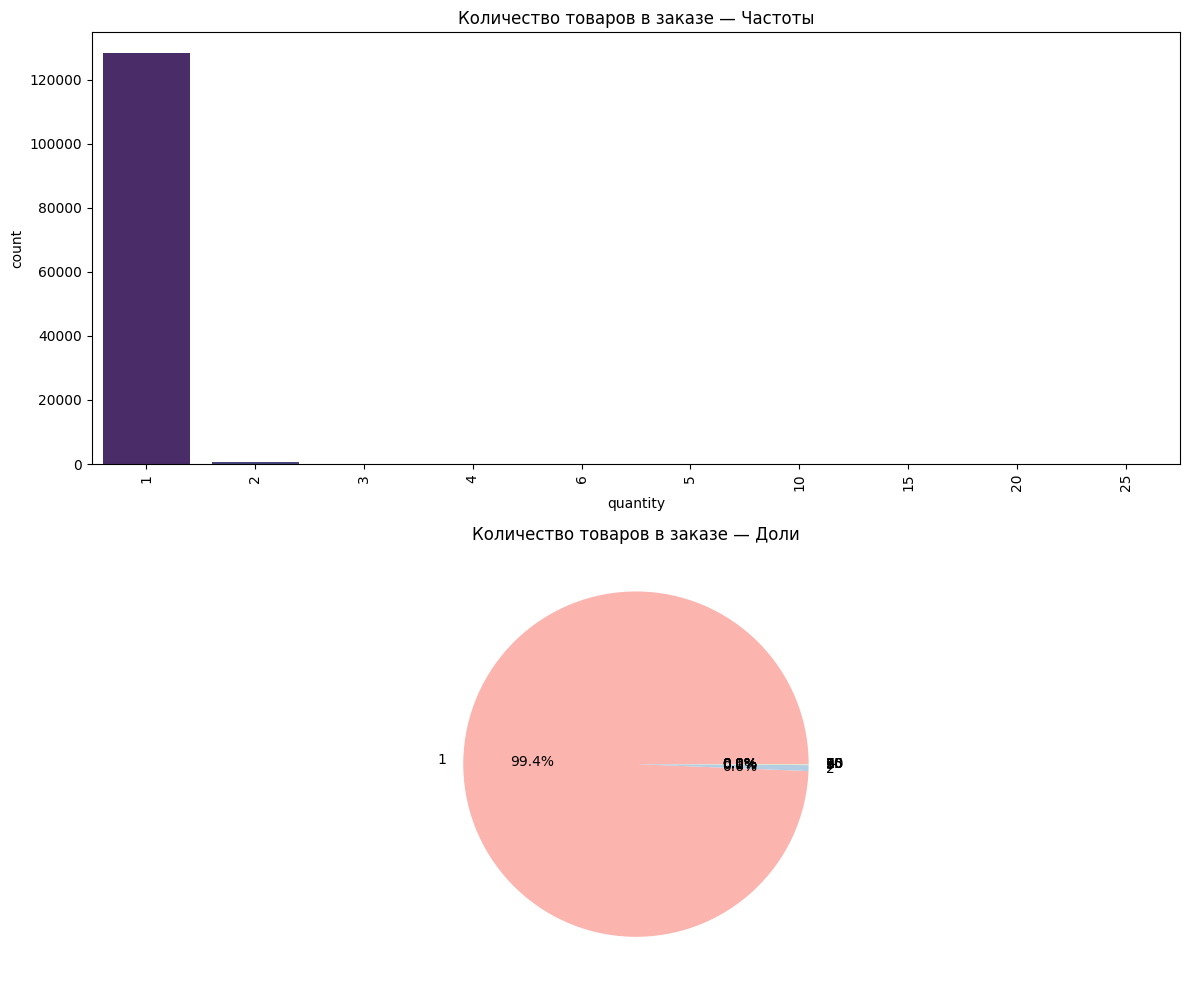

1     128352
2        714
3         86
4         12
6          4
5          3
10         3
15         3
20         2
25         2
Name: quantity, dtype: int64


In [29]:
categorical_features(purchases, 'quantity', title='Количество товаров в заказе')

99.5% заказов на один товар.

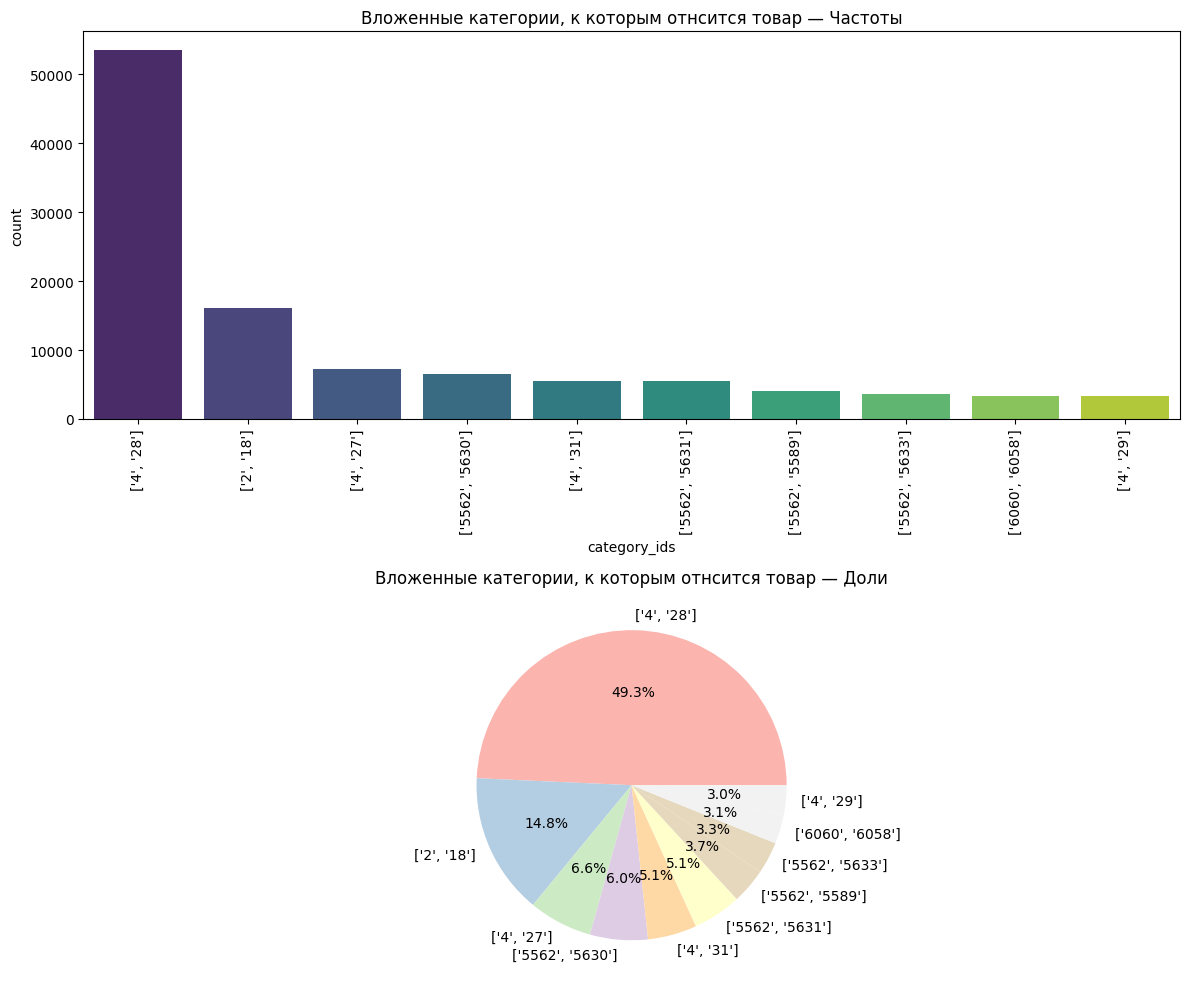

['4', '28']         53564
['2', '18']         16036
['4', '27']          7223
['5562', '5630']     6543
['4', '31']          5562
['5562', '5631']     5494
['5562', '5589']     4007
['5562', '5633']     3626
['6060', '6058']     3358
['4', '29']          3280
Name: category_ids, dtype: int64


In [30]:
categorical_features(purchases, 'category_ids', title='Вложенные категории, к которым отнсится товар')

49.3% товаров относятся к категориям ['4', '28'], 14.8% к категориям ['2', '18'].

**Message**

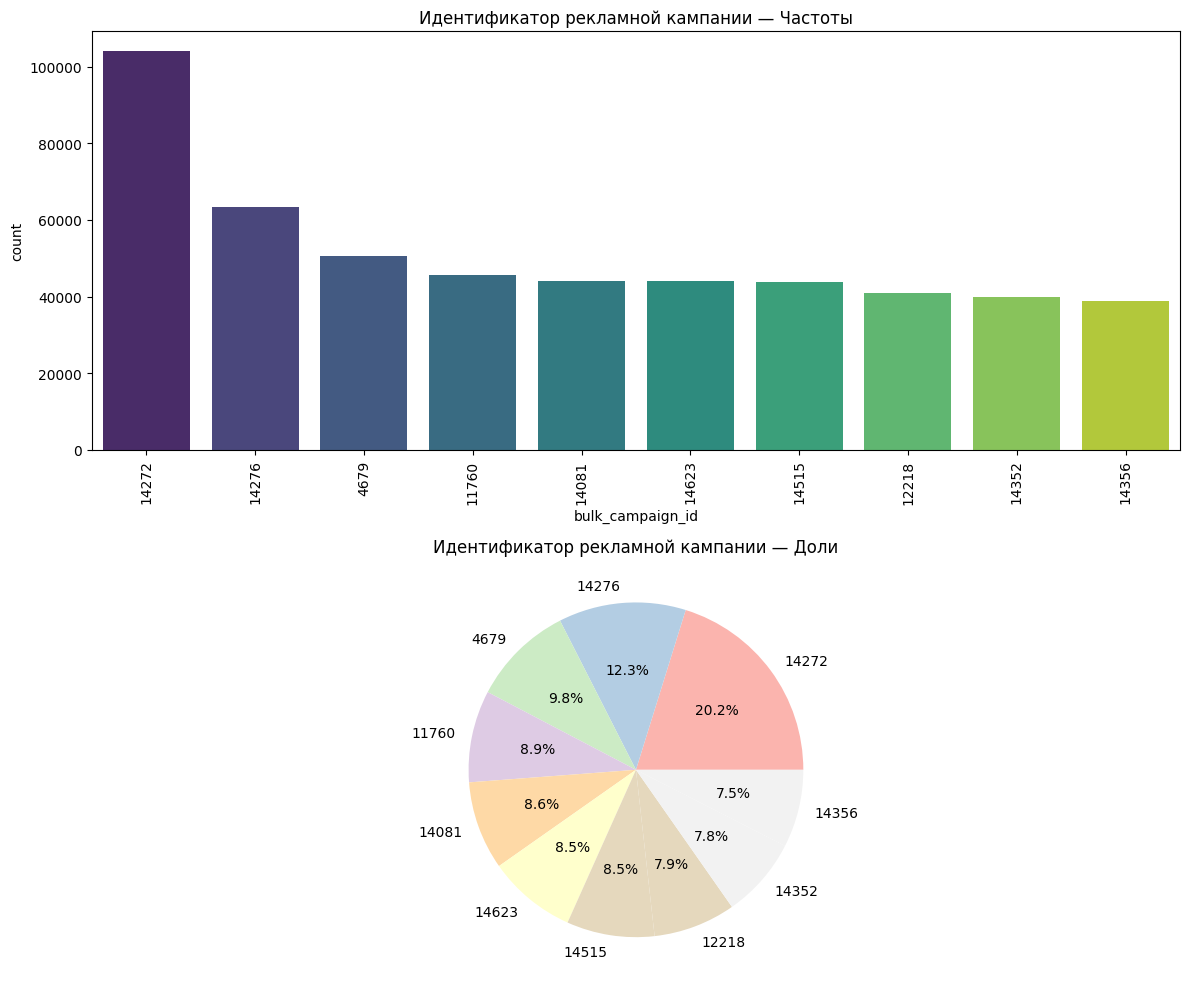

14272    104060
14276     63362
4679      50621
11760     45745
14081     44067
14623     44044
14515     43700
12218     40926
14352     39983
14356     38729
Name: bulk_campaign_id, dtype: int64


In [31]:
categorical_features(messages, 'bulk_campaign_id', title='Идентификатор рекламной кампании')

Самая многочисленная рекламная компания (более 100 тыс. сообщений) у рекламной компании под идентификатором 14272.

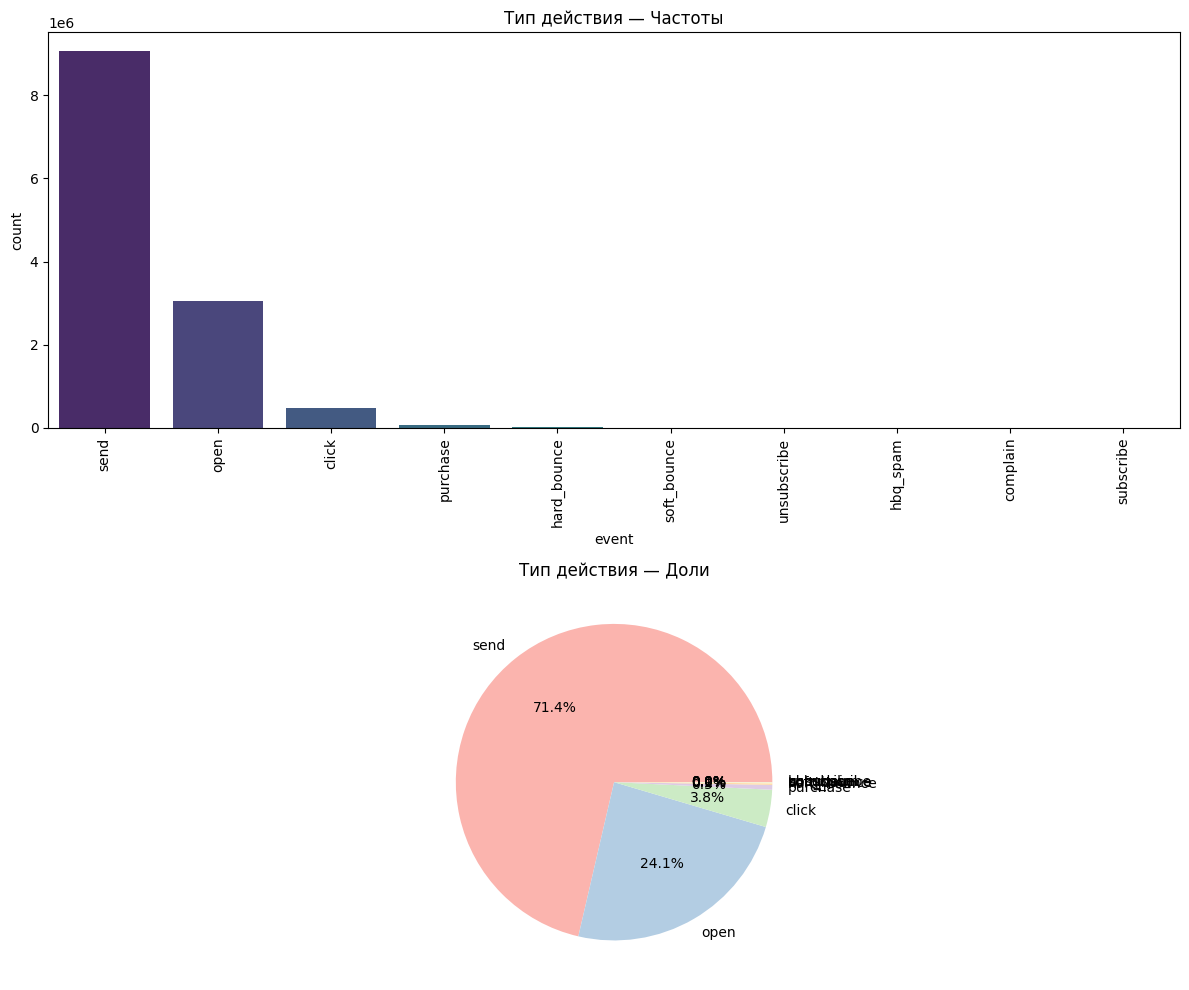

send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
Name: event, dtype: int64


In [32]:
categorical_features(messages, 'event', title='Тип действия')

Тоже следует уредить эти категории. Можно по трем направлениям - `negative`: unsubscribe, hbq_spam, complain; `problem_send`: hard_bounce, soft_bounce; `positive` - click, purchase, subscribe; `neutral`: send, open.

In [33]:
negative = ['unsubscribe', 'hbq_spam', 'complain']
problem_send = ['hard_bounce', 'soft_bounce']
positive = ['click', 'purchase', 'subscribe']
neutral = ['send', 'open']

def categorize_event(event):
    if event in negative:
        return 'negative'
    elif event in problem_send:
        return 'problem_send'
    elif event in positive:
        return 'positive'
    else:
        return 'neutral'

messages['event'] = messages['event'].apply(categorize_event)

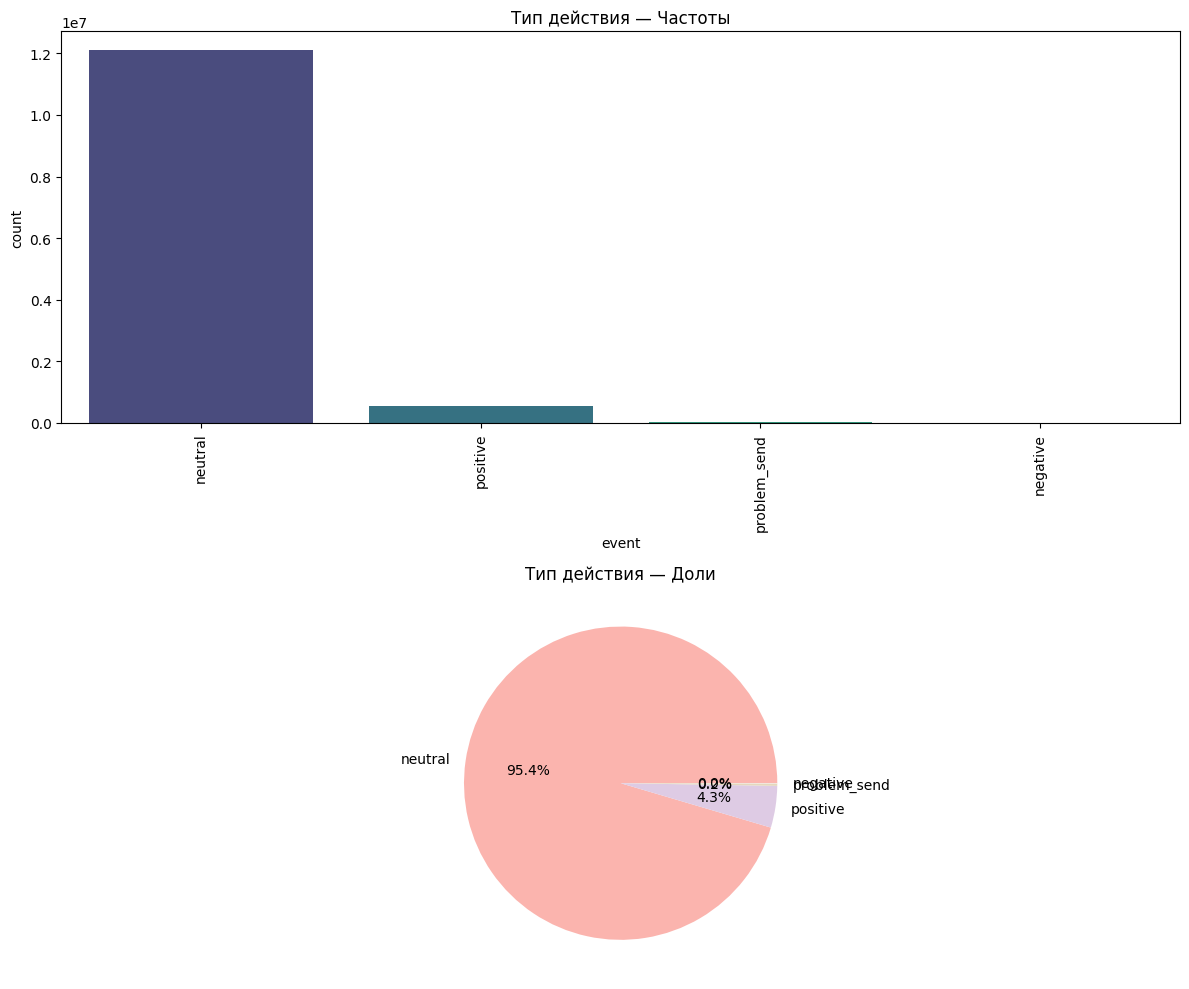

neutral         12110656
positive          546004
problem_send       30345
negative            4183
Name: event, dtype: int64


In [34]:
categorical_features(messages, 'event', title='Тип действия')

95% клиентов нейтрально реагировали на рассылку, 4% позитивно - кликали или совершали покупку.

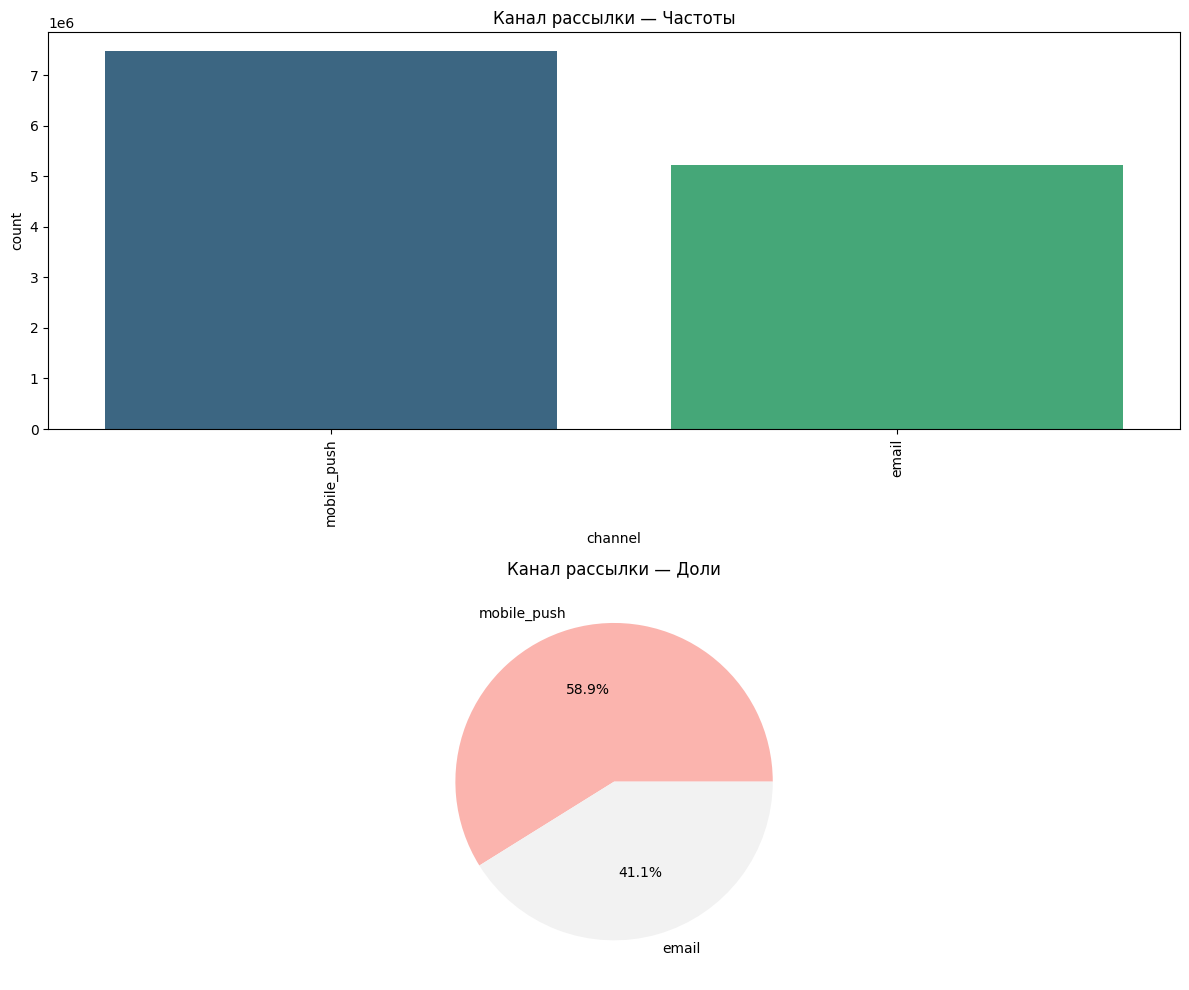

mobile_push    7470472
email          5220716
Name: channel, dtype: int64


In [35]:
categorical_features(messages, 'channel', title='Канал рассылки')

59% сообщений приходили в виде мобильных уведомлений.

**Target**

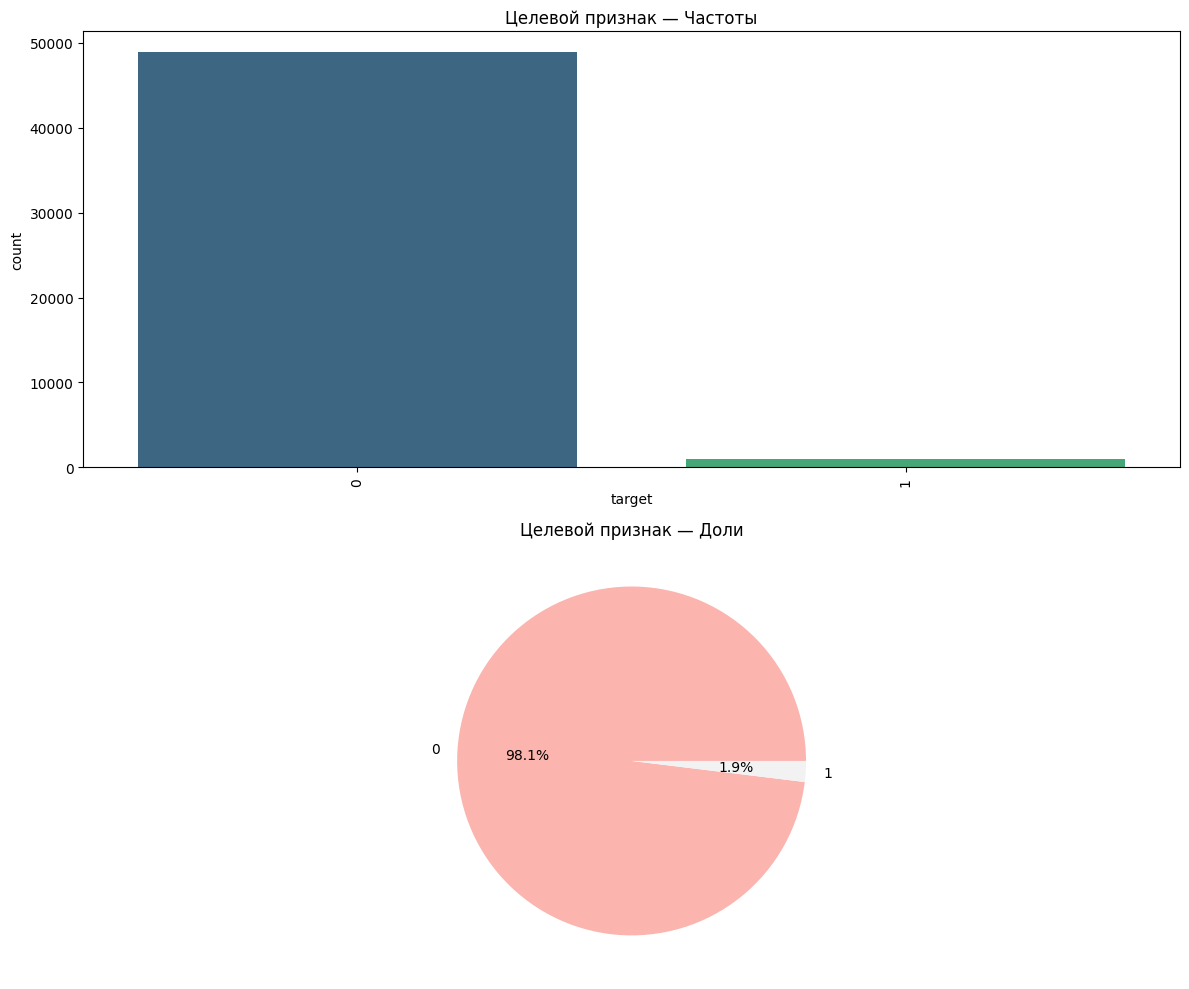

0    48888
1      961
Name: target, dtype: int64


In [36]:
categorical_features(target, 'target', title='Целевой признак')

98% клиентов не совершили покупку в течении 90 дней. Сильный дисбаланс классов, нужно будет обработать.

##### Количественные признаки

In [37]:
def quantitative_features(df, attribute, title='', bins=20):
    """
    Визуализация количественного признака:
    - Гистограмма 
    - Boxplot

    Параметры:
        df: DataFrame
        attribute: Название числового признака
        title: Заголовок графиков
        bins: Кол-во бинов в гистограмме
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    sns.histplot(df[attribute], kde=True, bins=bins, ax=ax[0], color=sns.color_palette("crest")[4])
    ax[0].set_title(f'{title} — Распределение', fontsize=14)
    ax[0].set_xlabel(attribute)
    ax[0].set_ylabel('Количество')

    # Boxplot
    sns.boxplot(x=df[attribute], ax=ax[1], palette="ch:s=-.2,r=.6")
    ax[1].set_title(f'{title} — Boxplot', fontsize=14)
    ax[1].set_xlabel(attribute)

    plt.tight_layout()
    plt.show()

    print(df[attribute].describe())

**Purchases**

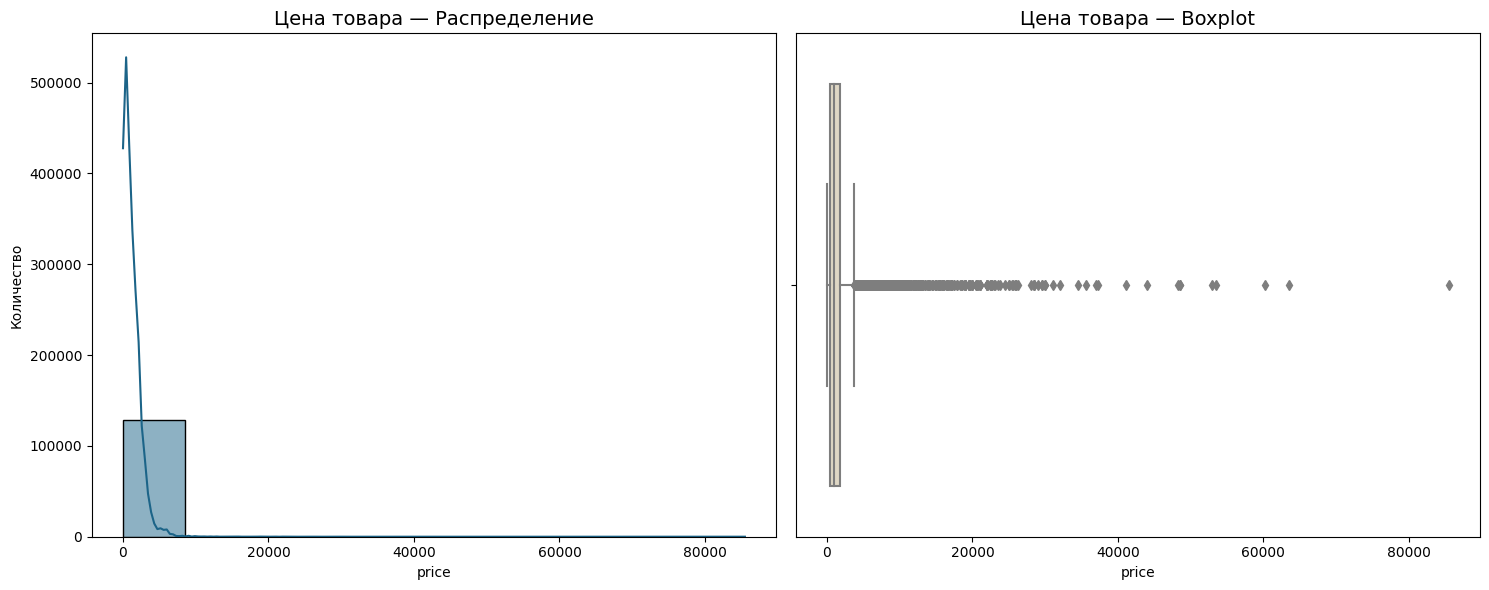

count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64


In [38]:
quantitative_features(purchases, 'price', title='Цена товара', bins=10)

Удалим выбросы, заменим на nan.

In [39]:
purchases = purchases.query('price >10 and price <20000')

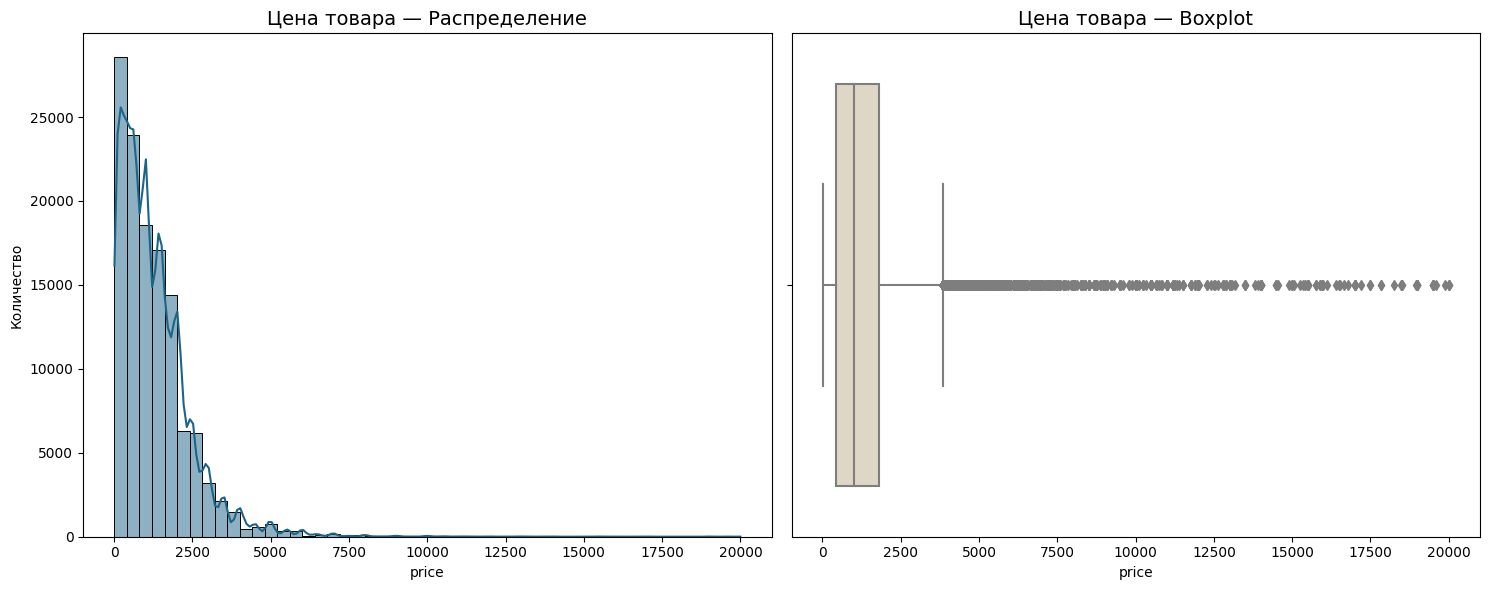

count    124958.000000
mean       1293.329983
std        1197.691335
min          11.000000
25%         438.000000
50%         999.000000
75%        1799.000000
max       19999.000000
Name: price, dtype: float64


In [40]:
quantitative_features(purchases, 'price', title='Цена товара', bins=50)

In [41]:
purchases.groupby('client_id').size()

client_id
1515915625468060902    5
1515915625468061003    6
1515915625468061099    1
1515915625468061100    1
1515915625468061170    7
                      ..
1515915626010261344    1
1515915626010266132    1
1515915626010439406    1
1515915626010443527    1
1515915626010443624    1
Length: 49771, dtype: int64

Потеряли только 78 клиентов из финального датасета, допустимо.   
Большинство товаров стоят от 11 до 1000 долларов.

##### Датированные признаки

In [42]:
def analyze_datetime_feature(df, date_column, time_unit='year', title=None):
    """
    Анализ и визуализация столбца с датами.
    """
    df_copy = df.copy()
    df_copy = df_copy.dropna(subset=[date_column])
    df_copy['year'] = df_copy[date_column].dt.year
    df_copy['month'] = df_copy[date_column].dt.month

    if time_unit == 'year':
        time_column = 'year'
    elif time_unit == 'month':
        time_column = 'month'
    else:
        raise ValueError("time_unit должен быть 'year' или 'month'")

    plt.figure(figsize=(10, 5))
    sns.histplot(df_copy[time_column], bins=len(df_copy[time_column].unique()), color='skyblue', edgecolor='black')
    
    plt.xlabel('Год' if time_unit == 'year' else 'Месяц')
    plt.ylabel('Количество записей')
    plt.title(title or f'Распределение по {time_unit}', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if time_unit == 'year':
        counts = df_copy.groupby(['year', 'month']).size().unstack().fillna(0)
        percentage = counts.div(counts.sum(axis=1), axis=0)

        percentage.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
        plt.xlabel('Год')
        plt.ylabel('Доля записей')
        plt.title(f'{title or "Доля записей"} по месяцам', fontsize=14, fontweight='bold')
        plt.legend(title='Месяц', labels=[
            'Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
            'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'
        ], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

**Purchases**

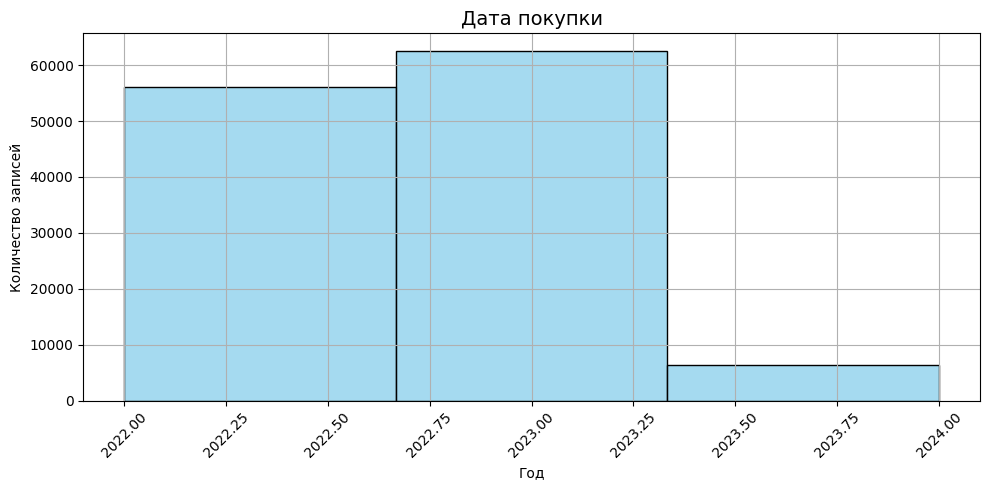

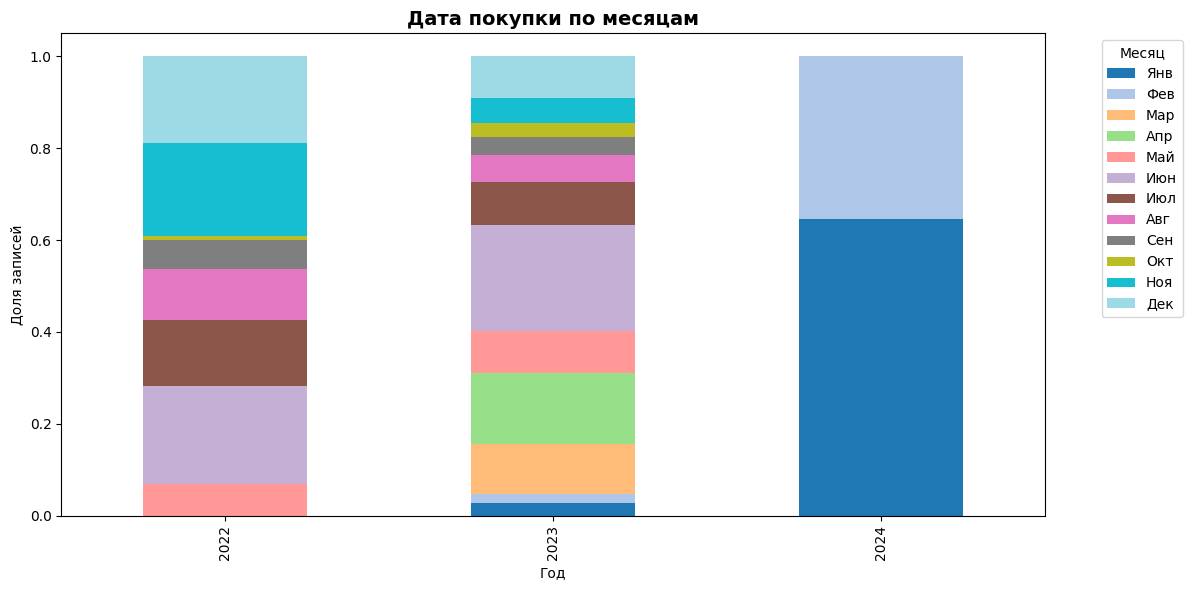

In [43]:
analyze_datetime_feature(purchases, 'date', 'year', 'Дата покупки')

Данные о покупках представлены с 2022 по начало 2024 года. Можно отметить, что и в 2022 и 2023 годах больше всего покупок было совершено в летние месяцы.

**Messages**

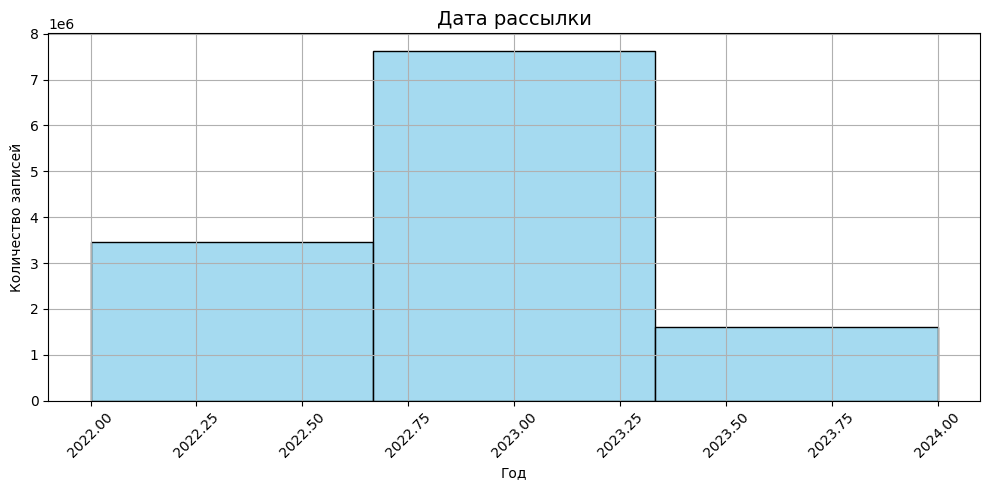

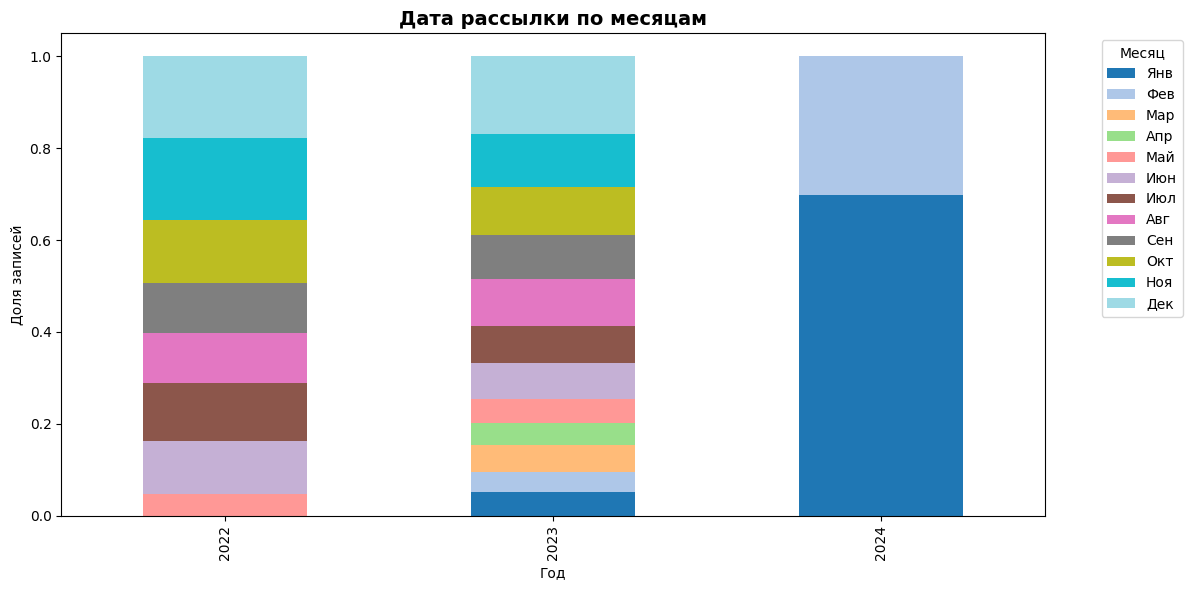

In [44]:
analyze_datetime_feature(messages, 'date', 'year', 'Дата рассылки')

Видно, что около 40% рассылки 2022 и 2023 года было отправлено с октября по декабрь, предположу, что это связано с новогодними праздниками.

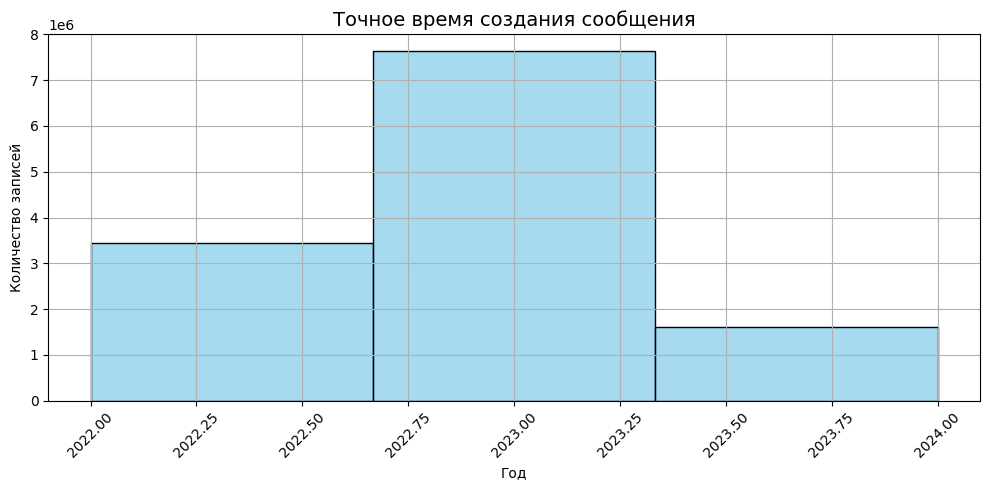

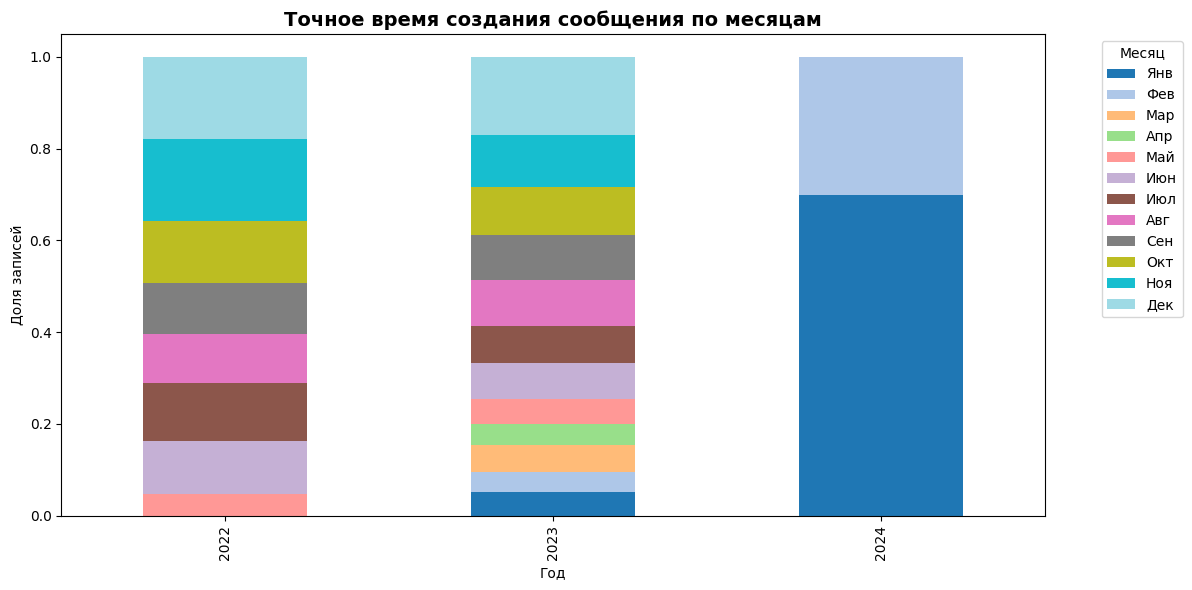

In [45]:
analyze_datetime_feature(messages, 'created_at', 'year', 'Точное время создания сообщения')

Картина почти такая же, как и при исследовании столбца "Дата рассылки". Скорее всего дата создания и рассылки близко совпадают. Время исследовать не будем.

## Промежуточный вывод

**Задача:** изучить данные.  
1. Данные загружены в три датафрема `purchases` - 202208 строк 6 столбцов, `messages` - 12739798 строк 7 столбцов, `target` - 49849 строк 2 столбца. 
2.  Типы данных приведены к соответсвующим, пропуски не обнаружены, дубликаты обнаруженые в `purchases` и `messages` удалены.
3.  Урежены количества категорий в столбцe *'category_ids'* датафрейма `purchases` и в столбце *'event'* датафрейма `messages`.
4.  При исследовательком анализе были удалены выбросы в столбце *'price'*  датафрейма `purchases`.
5.  Так же выявлено, что большинство заказов: включало себя всего 1 товар, категория обычно ['4', '28'], самая многочисленная рекламная компания 14272, большинство клиентов реагировали на рекламу нейтрально(мксимум что делали - открывали письмо, лиюо не реагировали), рассылка преимущественно в виде мобильных уведомлений, клиенты редко возвращаются за повторной покупкой. Цена покупки обычно от 500 до 1000 долларов, данные о покупках представлены с 2022 по начало 2024 года, в 2022 и 2023 годах больше всего покупок было совершено в летние месяцы.
6.  Выявлен дисбаланс классов целевого признака.

# 2. Разработка полезных признаков

Объединим таблицы заодно сагрегируем некоторые признаки. Агрегация необходима, так как на одного клиента проиходится много покупок и рассылок.

- `total_spent` — сколько клиент потратил всего
- `active_day`s — как долго клиент был активен (от первой до последней покупки)
- `total_messages` — сколько сообщений было отправлено клиенту
- `top1_category_purchases` — в какую категорию покупал чаще всего
- `last_purchase_days` — сколько дней прошло с первой покупки до последней
- `spend_bin` — бинирование total_spent
- `cat_diversity` — бинирование unique_categories
- `purchase_bin` — бинирование по числу покупок
- `positive` — позитивная реакция на рассылку

In [46]:
def features_clean(purchases, messages, target_df):

    purchases['date'] = pd.to_datetime(purchases['date'])
    purchases['spent'] = purchases['price'] * purchases['quantity']

    agg = purchases.groupby('client_id').agg(
        total_spent=('spent', 'sum'),
        n_purchases=('date', 'count'),
        first_purchase=('date', 'min'),
        last_purchase=('date', 'max')
    ).reset_index()

    agg['active_days'] = (agg['last_purchase'] - agg['first_purchase']).dt.days
    agg.drop(columns=['first_purchase'], inplace=True)

    cat_counts = purchases.groupby(['client_id', 'category_ids']).size().reset_index(name='count')
    cat_counts = cat_counts.sort_values(['client_id', 'count'], ascending=[True, False])
    top1 = cat_counts.groupby('client_id').nth(0).reset_index().rename(columns={'count': 'top1_category_purchases'})
    agg = agg.merge(top1[['client_id', 'top1_category_purchases']], on='client_id', how='left')

    unique_cats = purchases.groupby('client_id')['category_ids'].nunique().reset_index(name='unique_categories')
    agg = agg.merge(unique_cats, on='client_id', how='left')

    messages['date'] = pd.to_datetime(messages['date'])
    total_msgs = messages.groupby('client_id').size().reset_index(name='total_messages')

    positive_counts = messages[messages['event'] == 'positive'].groupby('client_id').size().reset_index(name='positive')
    msg_agg = total_msgs.merge(positive_counts, on='client_id', how='left')


    features = agg.merge(msg_agg, on='client_id', how='left')
    features = features.merge(target_df[['client_id', 'target']], on='client_id', how='left')

    base_date = features['last_purchase'].min()
    features['last_purchase_days'] = (features['last_purchase'] - base_date).dt.days
    features.drop(columns=['last_purchase'], inplace=True)

    features['spend_bin'] = pd.cut(
        features['total_spent'],
        bins=[0, 1000, 3000, 7000, np.inf],
        labels=['very_low', 'low', 'medium', 'high']
    )

    def bin_cat_div(x):
        if x == 1: return 'single'
        elif x == 2: return 'few'
        elif 3 <= x <= 5: return 'several'
        else: return 'many'

    features['cat_diversity'] = features['unique_categories'].apply(bin_cat_div)

    def bin_purchases(x):
        if x == 1: return 'one'
        elif x == 2: return 'two'
        elif 3 <= x <= 5: return 'few'
        elif 6 <= x <= 10: return 'medium'
        else: return 'many'

    features['purchase_bin'] = features['n_purchases'].apply(bin_purchases)

    features['is_active_multiple_days'] = (features['active_days'] > 0).astype(int)

    wanted_cols = [
        'client_id', 'total_spent', 'active_days', 'total_messages', 'positive',
        'top1_category_purchases', 'last_purchase_days', 'spend_bin',
        'cat_diversity', 'purchase_bin', 'is_active_multiple_days', 'target'
    ]

    return features[wanted_cols]


In [47]:
df = features_clean(purchases, messages, target)

In [48]:
display(df.head())
df.info() 

,client_id,total_spent,active_days,total_messages,positive,top1_category_purchases,last_purchase_days,spend_bin,cat_diversity,purchase_bin,is_active_multiple_days,target
0,1515915625468060902,4795,0,177.0,15.0,3.0,11,medium,few,few,0,0
1,1515915625468061003,14135,0,165.0,6.0,6.0,233,high,single,medium,0,1
2,1515915625468061099,299,0,276.0,8.0,1.0,1,very_low,single,one,0,0
3,1515915625468061100,1049,0,428.0,2.0,1.0,635,low,single,one,0,0
4,1515915625468061170,14095,83,293.0,19.0,6.0,397,high,few,medium,1,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 49771 entries, 0 to 49770
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   client_id                49771 non-null  int64   
 1   total_spent              49771 non-null  int64   
 2   active_days              49771 non-null  int64   
 3   total_messages           41917 non-null  float64 
 4   positive                 39404 non-null  float64 
 5   top1_category_purchases  49769 non-null  float64 
 6   last_purchase_days       49771 non-null  int64   
 7   spend_bin                49771 non-null  category
 8   cat_diversity            49771 non-null  object  
 9   purchase_bin             49771 non-null  object  
 10  is_active_multiple_days  49771 non-null  int64   
 11  target                   49771 non-null  int64   
dtypes: category(1), float64(3), int64(6), object(2)
memory usage: 4.6+ MB


Получилась такая итоговая таблица. Пропуски будем заполнять позже. 

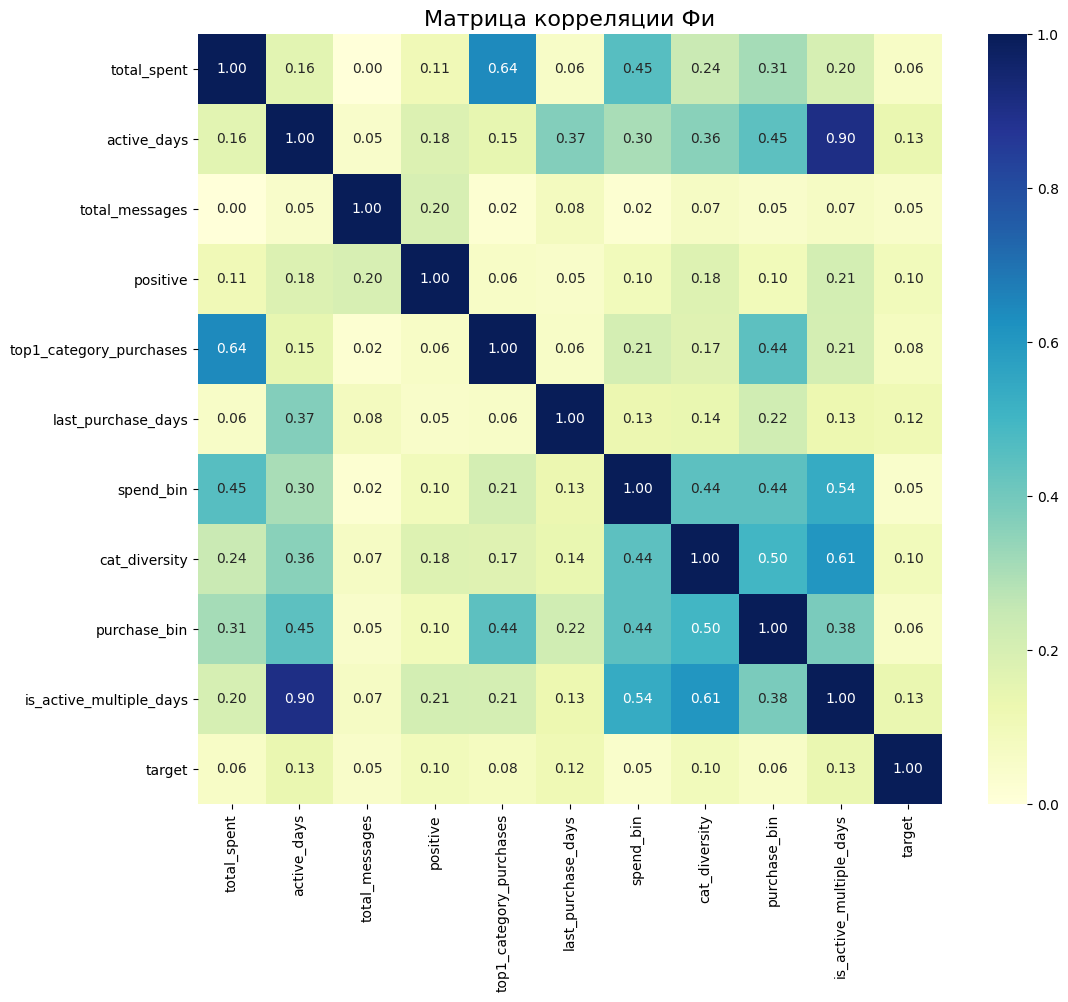

In [49]:
df = df.set_index('client_id')

interval_cols = df.select_dtypes(include=['number']).columns.tolist()
phik_overview = df.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10)) 
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Матрица корреляции Фи', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Четкой линейной зависимости у таргета в признаками нет. Имеется слабая зависимость у ЦП со столбцами `active_day`, `last_purchase_days`, `positive`, `cat_diversity`. Имеется на грани мультиколлинеарности зависимость между `active_day` и `is_active_multiple_daes`, пока я не хочу ее убирать, посмотрим после обучения одели на важность признаков и тогда примем решение.

Так же возможно такая слабая зависимость из-за сильной слабости положительного класса ЦП.

## Промежуточный вывод

**Задача:** разработать полезные признаки.  
1.  Все исходные датафреймы сагрегированы в единый `df` состоящий из 49771 строк и 12 столбцов.
2.  11 столбцов являются новыми признаками создаными из исходных данных с целью лучше уловить поведение клиентов и его связь с целевым признаком.
3.  Выяввлено, что признаки не имеют прямой линейной зависимости с целевым признаком.


# 3. Создание модели для классификации пользователей

Зависимость таргета от остальных признаков явно не линейная, поэтому остановим выбор моделей на: LogisticRegression, Random Forest, XGBoost, KNN.  
Подготовим выборки.
Так же вспомним, что имеется дисбаланс классов у целевого признака. 

In [50]:
df.columns

Index(['total_spent', 'active_days', 'total_messages', 'positive',
       'top1_category_purchases', 'last_purchase_days', 'spend_bin',
       'cat_diversity', 'purchase_bin', 'is_active_multiple_days', 'target'],
      dtype='object')

In [51]:
X = df.drop(columns='target')
y = df['target']

In [52]:
X_test, X_train, y_test, y_train  = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12443, 10) (12443,)
(37328, 10) (37328,)


In [53]:
num_features = [
    'total_spent',
    'active_days',
    'total_messages',
    'positive',
    'top1_category_purchases',
    'last_purchase_days',
    'is_active_multiple_days'
]

cat_features = [
    'spend_bin',
    'cat_diversity',
    'purchase_bin'
]

In [54]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        categories=[['very_low', 'low', 'medium', 'high'], ['single', 'several', 'many'],['one', 'two', 'few', 'medium', 'many']],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

base_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersample', RandomUnderSampler(random_state=RANDOM_STATE)),
    ('classifier', RandomForestClassifier())
])

In [55]:
models = [
    {
        'classifier': [LogisticRegression(max_iter=1000, solver='liblinear')],
        'classifier__C': [0.1, 1, 10],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [5, 15]
    },
    {
        'classifier': [XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE)],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [5, 10, 15],
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__subsample': [0.7, 1],
        'classifier__colsample_bytree': [0.7, 1],
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5],
        'classifier__metric': ['euclidean', 'manhattan']
    }
]

In [56]:
%%time
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    base_pipeline,
    param_grid=models,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 85 candidates, totalling 255 fits


/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator.

CPU times: user 2.35 s, sys: 195 ms, total: 2.55 s
Wall time: 16.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['total_spent',
                                                                          'active_days',
                                                                          'total_messages',
                                                                          'positive',
                                                                          'top1_category_purchases',
                                                                          'last_purchase_days',
                                                                          'is_active_multiple_days']),
                                                                        (...
                                                       random_state=42, ...)],
                          'classifier__colsample_bytree': [0.7, 1],
                          'classifier__learning_rate': [0.05, 0.1],
                          'classifier__max_depth': [5, 10, 15],
                          'classifier__n_estimators': [100, 300, 500],
                          'classifier__subsample': [0.7, 1]},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__metric': ['euclidean', 'manhattan'],
                          'classifier__n_neighbors': [3, 5]}],
             scoring='roc_auc', verbose=1)

Лучшая модель RandomForestClassifier с гиперпараметрами max_depth=5, n_estimators=500. Оценим метрики.

#### Промежуточный вывод

**Цель:** создание модели для классификации пользователей.  
1. Созданы пайплайны с препроцессорами и с гиперапарметрами для подбора.
2.  Подбор гиперпараметров осуществлялся с помощью GridCV. Категориальные признаки кодированы OrdinalEncoder, пропуски заполнены SimpleImputer - медианой для числовых и самым популярным значением для категориальных.
3.  Лучшая модель RandomForestClassifier с максимальной глубиной 5.

# 4. Улучшение модели и максимизация метрики roc-auc

In [57]:
cv_results = pd.DataFrame(grid.cv_results_)
final_results, final_reports = [], {}

for i in range(len(cv_results)):
    row = cv_results.iloc[i]
    model_name = str(row['param_classifier'])
    estimator = clone(grid.best_estimator_).set_params(**row['params'])
    
    y_probs = cross_val_predict(
        estimator, X_train, y_train,
        cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        
    roc_auc = roc_auc_score(y_train, y_probs)
    precision, recall, thresholds = precision_recall_curve(y_train, y_probs)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)

    best_threshold = thresholds[best_idx]
    y_pred = (y_probs >= best_threshold).astype(int)

    final_results.append({
        'model': model_name,
        'ROC-AUC': roc_auc,
        'best_f1': f1_scores[best_idx],
        'best_threshold': best_threshold,
        'precision': precision[best_idx],
        'recall': recall[best_idx],
        'сonfusion_matrix': confusion_matrix(y_train, y_pred)
    })

    final_reports[model_name] = classification_report(y_train, y_pred, output_dict=True, digits=4)

final_df = pd.DataFrame(final_results).sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)

print('Итоговая таблица метрик:')
display(final_df[['model', 'ROC-AUC', 'best_f1', 'best_threshold', 'precision', 'recall']].round(4).head(10))

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklear

Итоговая таблица метрик:


/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklear

,model,ROC-AUC,best_f1,best_threshold,precision,recall
0,RandomForestClassifier(),0.7191,0.1046,0.7147,0.0650,0.2669
1,RandomForestClassifier(max_depth=5),0.7188,0.1065,0.7262,0.0680,0.2458
2,"XGBClassifier(base_score=None, booster=None, c...",0.7181,0.1028,0.7817,0.0607,0.3347
3,"RandomForestClassifier(max_depth=5, n_estimato...",0.7160,0.1069,0.6933,0.0644,0.3136
4,"XGBClassifier(base_score=None, booster=None, c...",0.7160,0.1083,0.8580,0.0677,0.2712
5,"XGBClassifier(base_score=None, booster=None, c...",0.7147,0.1131,0.8229,0.0688,0.3178
6,"XGBClassifier(base_score=None, booster=None, c...",0.7130,0.0942,0.8383,0.0593,0.2288
7,"XGBClassifier(base_score=None, booster=None, c...",0.7123,0.1085,0.8361,0.0651,0.3263
8,"XGBClassifier(base_score=None, booster=None, c...",0.7117,0.0941,0.8223,0.0575,0.2585
9,"LogisticRegression(C=1, max_iter=1000, solver=...",0.7113,0.0984,0.7202,0.0582,0.3178


Определим еще раз цель предсказания: в ТЗ указано, что нужно предсказать вероятность покупки в течение 90 дней.  

**Проблема:** данные сильно дисбанасированны, моделям тяжело научиться хорошо предсказывать класс 1.

Перефразирую цель: максимально охватить потенциальных покупателей (класс 1), даже если это приведёт к некоторому числу ложных срабатываний. Поэтому приоритетной метрикой является Recall. Однако, чтобы не перегрузить маркетинг ложными таргетами, Precision также должен оставаться на приемлемом уровне (хотя бы 0.2-0.3). 

**Следовательно** выбираем модель лучшую по GridCV у нее хороший баланс Precision и Recall. Если честно я обучила XGBClassifier, но она на таких несбалансированных данных дала плохой результат, очень плохо уловила 1 класс и дала упад метрик. RandomForestClassifier справляется стабильнее.

**Следующий шаг** - изучим какие признаки повлияли больше всего на предсказание, затем поиграем с порогом классификации, поберем такой, чтобы Recall был высоким.

In [58]:
final_model = RandomForestClassifier(
    max_depth=5,
    random_state=RANDOM_STATE
)

X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

preprocessor.fit(X_train_part)

X_train_processed = preprocessor.transform(X_train_part)
X_val_processed = preprocessor.transform(X_val)

final_model.fit(X_train_processed, y_train_part)

y_val_proba = final_model.predict_proba(X_val_processed)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_val_proba)
print(f"ROC-AUC на валидационных данных: {roc_auc_val:.4f}")

ROC-AUC на валидационных данных: 0.7709


ROC-AUC вышел хороший. Оценим важность признаков.

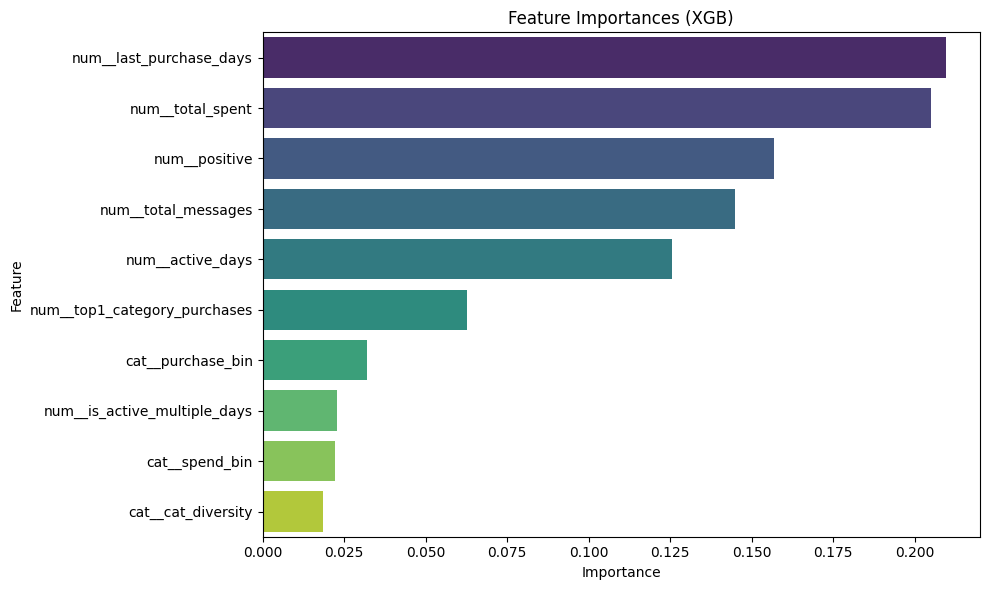

In [59]:
feature_names = preprocessor.get_feature_names_out()
feat_imp = pd.Series(final_model.feature_importances_, index=feature_names)

feat_imp_df = pd.DataFrame({
    'feature': feat_imp.index,
    'importance': feat_imp.values
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='importance', y='feature', palette='viridis')
plt.title('Feature Importances (XGB)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Ни один из признаков не заслуживает удаления, все вносят вклад в предсказание. Оставим как есть.

Лучший порог по F1: 0.0440
              precision    recall  f1-score   support

           0     0.9842    0.9466    0.9650      2435
           1     0.1156    0.3148    0.1692        54

    accuracy                         0.9329      2489
   macro avg     0.5499    0.6307    0.5671      2489
weighted avg     0.9654    0.9329    0.9478      2489



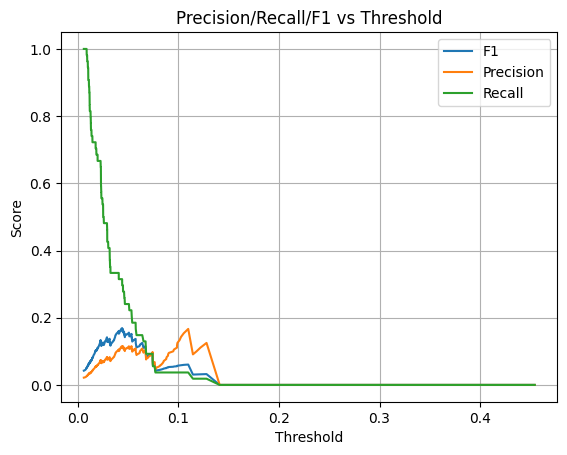

In [60]:
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Лучший порог по F1: {best_threshold:.4f}")

y_val_pred = (y_val_proba >= best_threshold).astype(int)

print(classification_report(y_val, y_val_pred, digits=4))

plt.plot(thresholds, f1_scores[:-1], label='F1')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision/Recall/F1 vs Threshold')
plt.grid(True)
plt.show()

Precision 11.5% — из всех предсказанных «положительных» только 1 из 9 реально правильный, но улавливает 31% положительных.

#### Промежуточный вывод

**Цель:** улучшить модель и максимизировать метрику roc-auc.
1. Сильнее всего влияет на предсказание `last_purchase_day`, `total_spent`.
2.  Оценка финальной модели осуществлена по Recall так как важнее не упустить редких повторных покупателей (класс 1), но модели имеют сложность научиться предсказывать этот класс из-за качества данных.
3.  Определен порог классификации = 0.044

# 5. Тестирование

ROC-AUC на тестовых данных: 0.7197
              precision    recall  f1-score   support

           0     0.9847    0.9466    0.9653     36604
           1     0.0865    0.2555    0.1292       724

    accuracy                         0.9332     37328
   macro avg     0.5356    0.6011    0.5473     37328
weighted avg     0.9673    0.9332    0.9491     37328



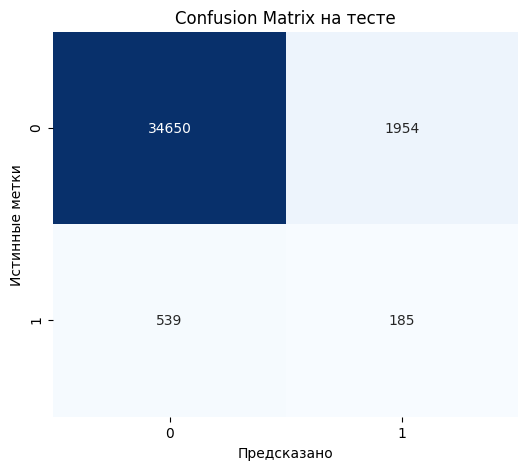

In [61]:
X_test_processed = preprocessor.transform(X_test)

y_test_proba = final_model.predict_proba(X_test_processed)[:, 1]

y_test_pred =  (y_test_proba >= best_threshold).astype(int)

roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC на тестовых данных: {roc_auc_test:.4f}")

print(classification_report(y_test, y_test_pred, digits=4))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказано')
plt.ylabel('Истинные метки')
plt.title('Confusion Matrix на тесте')
plt.show()

#### Промежуточный вывод

**Цель:** выполнить тестирование.
1. На тестовой выборке ROC_AUC = 0.72, модель уловила только 31% реального 1 класса, но это неплохой результат в нашем случае.

# Общий вывод


В рамках проекта была успешно решена задача прогнозирования вероятности покупки в течение 90 дней. Построена классификационная модель (RandomForestClassifier), достигшая ROC-AUC ≈ 0.72 на тестовой выборке, что указывает на адекватную способность модели различать потенциальных покупателей и незаинтересованных клиентов. Основной акцент при оценке делался на Recall, так как бизнесу важно не упустить потенциальных покупателей.

Несмотря на дисбаланс классов и ограниченность в данных о поведении клиентов, модель показывает полезную точность в реальных условиях — она способна идентифицировать около 31% клиентов, действительно готовых к покупке.

**Рекомендации по улучшению данных:**
- Больше поведенческих признаков
- Добавить логи посещения сайта/приложения (клики, просмотры, добавления в корзину, время на сайте)
- Больше контекста о покупках
- Если возможно, добавить данные о скидках, промокодах, способах оплаты, регионе и устройстве — они могут сильно влиять на лояльность.

**Практические советы для бизнеса**
- Персонализировать рассылки
- Использовать предсказанную модель для создания «умных» рассылок — выделять группу с высокой вероятностью покупки и адаптировать предложения под интересы (категории, сумма, частота).
- Запускать ретаргетинг по горячим клиентам.
- Показывать рекламу тем, у кого last_purchase_days и total_spent близки к клиентам, совершавшим повторные покупки.
- Поощрение за вторую покупку
- Предлагать бонусы или скидки через 30–60 дней после первой покупки, особенно в активный сезон (например, летом).